In [173]:

import pandas as pd
path = "/Users/benjaminwinsemius/DH_&_SA_project/Seattle_Book_Checkouts_2010_2017.csv"

df = pd.read_csv(path)

# kolommen droppen


print(df.columns.tolist())

for row in df:   # only first 5 rows
    print(row)

print(len(df))

['UsageClass', 'CheckoutType', 'MaterialType', 'CheckoutYear', 'CheckoutMonth', 'Checkouts', 'Title', 'Creator', 'Subjects', 'Publisher', 'PublicationYear']
UsageClass
CheckoutType
MaterialType
CheckoutYear
CheckoutMonth
Checkouts
Title
Creator
Subjects
Publisher
PublicationYear
581697


In [174]:
# Handle missing values

# Creator -> fill with 'Unknown'
df["Creator"] = df["Creator"].fillna("Unknown")

# Subjects -> keep but mark missing
df["Subjects"] = df["Subjects"].fillna("Unclassified")

# Publisher -> fill with 'Unknown'
df["Publisher"] = df["Publisher"].fillna("Unknown")

# PublicationYear -> convert to numeric, keep NaN
df["PublicationYear"] = pd.to_numeric(df["PublicationYear"], errors="coerce")


print(df.isnull().sum())


UsageClass              0
CheckoutType            0
MaterialType            0
CheckoutYear            0
CheckoutMonth           0
Checkouts               0
Title                   0
Creator                 0
Subjects                0
Publisher               0
PublicationYear    285577
dtype: int64


In [175]:
print("Number of unique subjects:", df["Subjects"].nunique())


Number of unique subjects: 51313


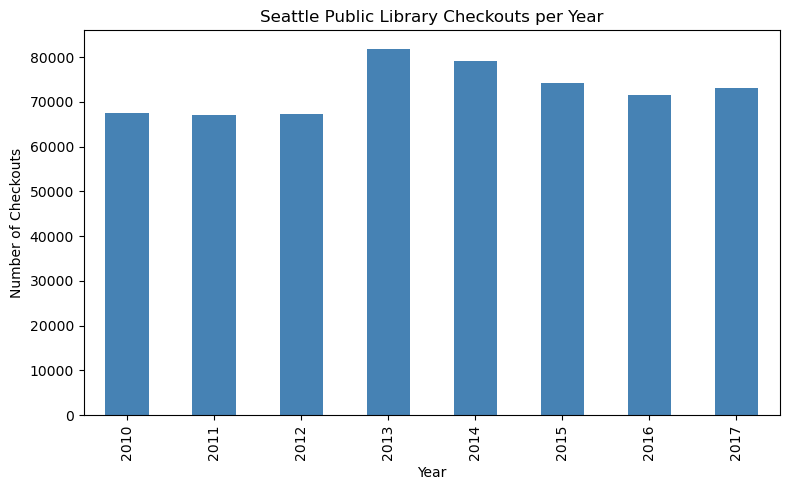

CheckoutYear
2010    67562
2011    67141
2012    67233
2013    81892
2014    79095
2015    74145
2016    71581
2017    73048
dtype: int64


In [176]:

if 'CheckoutYear' in df.columns:
    yearly = df.groupby('CheckoutYear').size()
else:
    
    df['CheckoutYear'] = pd.to_datetime(df['CheckoutDate']).dt.year
    yearly = df.groupby('CheckoutYear').size()


plt.figure(figsize=(8,5))
yearly.plot(kind='bar', color='steelblue')
plt.title("Seattle Public Library Checkouts per Year")
plt.xlabel("Year")
plt.ylabel("Number of Checkouts")
plt.tight_layout()
plt.show()


print(yearly)


In [186]:
subject_counts = df["Subjects"].value_counts().reset_index()
subject_counts.columns = ["Subject", "Count"]

print(subject_counts)  


                                                 Subject  Count
0                                           Unclassified   6131
1      Garfield Fictitious character Comic books stri...   1182
2                                        Fantasy Fiction   1171
3                                          Short stories    935
4                                           Dogs Fiction    742
...                                                  ...    ...
51308  Identity Psychology Juvenile fiction, Mothers ...      1
51309  Child Lee, Authors and readers, Fiction Author...      1
51310  Cities and towns Juvenile fiction, Lost childr...      1
51311  Colbeck Robert Fictitious character Fiction, L...      1
51312  Social change United States, Political culture...      1

[51313 rows x 2 columns]


In [187]:
# 1. Split subjects into multiple rows
df_exploded = df.assign(
    Subjects=df["Subjects"].str.split(",")
).explode("Subjects")

# 2. Clean text
df_exploded["Subjects"] = df_exploded["Subjects"].str.strip().str.lower()


categories = {
    "workers_social_justice": [
        
        "workers rights", "worker rights", "social justice",
         "union member", "union members",
        "community activist", "community activists",
        "economic inequality", "inequality", "inequities",
        "anti-capitalist", "anti-capitalism", "anticapitalist",
        "occupy wall street",
        "labor rights", "labour rights", "collective bargaining",
        "living wage", "minimum wage", "wage theft",
        "gig worker", "precarious work", "strike", "walkout",
        "picket", "solidarity", "organizing", "organising",
        "workers movement", "labor movement", "labour movement","youth activism"
    ],
    "Homelessness": [
        "homeless", "homelessness", "unhoused", "unhoused people", "unsheltered", "unsheltered homeless",
        "houseless" ,"street people",
        "housing insecurity", "housing crisis", "shelters", "homeless shelters", "shelter services",
        "transitional housing", "urban poor", "poverty", "extreme poverty", "drug abuse", "drug addiction",
        "substance abuse", "substance use", "substance dependence","opioid", "opioids", "opioid crisis", "opiate",
        "heroin", "cocaine", "crack cocaine", "meth", "methamphetamine", "fentanyl", "overdose", "drug overdose","rehab", "rehabilitation", "detox"
, "treatment programs","alcohol abuse", "alcoholism" ,"narcotics", "controlled substances"
    ],

}

def classify_subject(subj):
    for cat, keywords in categories.items():
        if any(k in subj for k in keywords):
            return cat
    return None

df_exploded["SubjectCategory"] = df_exploded["Subjects"].apply(classify_subject)


df_filtered = df_exploded.dropna(subset=["SubjectCategory"])


print(df_filtered["SubjectCategory"].value_counts())



SubjectCategory
Homelessness              4395
workers_social_justice     477
Name: count, dtype: int64


In [188]:

df_filtered["Date"] = pd.to_datetime(
    df_filtered["CheckoutYear"].astype(str) + "-" +
    df_filtered["CheckoutMonth"].astype(str) + "-01"
)


ts = (
    df_filtered.groupby(["Date", "SubjectCategory"])["Checkouts"]
    .sum()
    .reset_index()
)

print(ts.head())

        Date         SubjectCategory  Checkouts
0 2010-01-01            Homelessness        618
1 2010-01-01  workers_social_justice        110
2 2010-02-01            Homelessness        451
3 2010-02-01  workers_social_justice         48
4 2010-03-01            Homelessness        605


/var/folders/qm/w_kczhrn49569rq9hzbh0zc00000gn/T/ipykernel_34288/527703976.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Date"] = pd.to_datetime(


In [222]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

def its_analysis(ts, subject, event_date, window_months=6):
    

    # Selecteer categorie
    df = ts[ts["SubjectCategory"] == subject].copy()

    # Maandresolutie
    df = df.set_index("Date").resample("M")["Checkouts"].sum().reset_index()

    # Converteer datum
    event_date = pd.to_datetime(event_date)

    # Tijdvenster filter
    start_date = event_date - pd.DateOffset(months=window_months)
    end_date = event_date + pd.DateOffset(months=window_months)
    df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)].reset_index(drop=True)

    # Event index vinden
    event_idx = df.index[df["Date"] >= event_date][0]

    # Variabelen maken
    df["time"] = range(len(df))
    df["post_event"] = (df["Date"] >= event_date).astype(int)
    df["time_after_event"] = df["time"] - event_idx
    df["time_after_event"] = df["time_after_event"].clip(lower=0)

    # Regressiemodel
    X = sm.add_constant(df[["time", "post_event", "time_after_event"]])
    y = df["Checkouts"]
    model = sm.OLS(y, X).fit()

    # Resultaten printen
    print(f"\n--- ITS Results for {subject} (±{window_months} months) ---")
    print(model.summary())

    plt.figure(figsize=(10,5))
    plt.plot(df["Date"], y, label="Observed", color = "forestgreen")
    plt.plot(df["Date"], model.predict(X), label="Fitted", color="mediumseagreen")
    plt.axvline(event_date, color="black", linestyle="--", label=f"Event {event_date.date()}")
    plt.title(f"Interrupted Time Series: {subject} (±{window_months} months)")
    plt.xlabel("Date")
    plt.ylabel("Checkouts")
    plt.legend()
    plt.show()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
--- ITS Results for workers_social_justice (±6 months) ---

                            OLS Regression Results                            
Dep. Variable:              Checkouts   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     8.360
Date:                Wed, 15 Oct 2025   Prob (F-statistic):            0.00756
Time:                        20:46:20   Log-Likelihood:                -39.704
No. Observations:                  12   AIC:                             87.41
Df Residuals:                       8   BIC:                             89.35
Df Model:                           3                     

/Users/benjaminwinsemius/miniconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


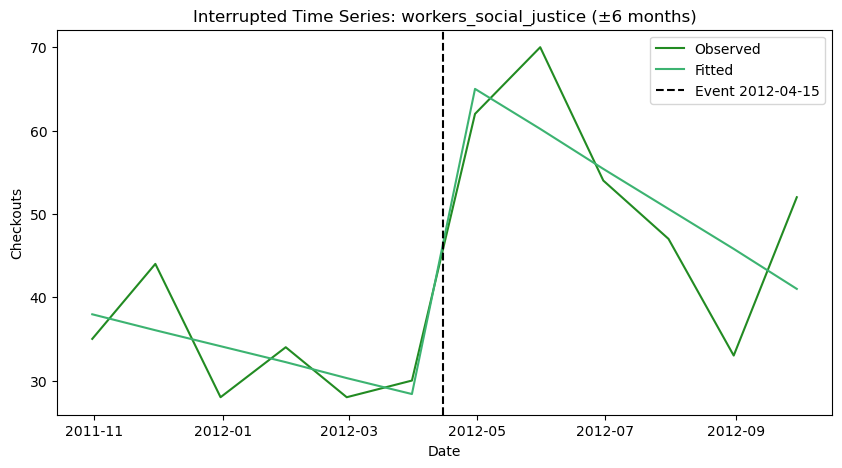

In [225]:
its_analysis(ts, "workers_social_justice", "2012-04-15", window_months=6)

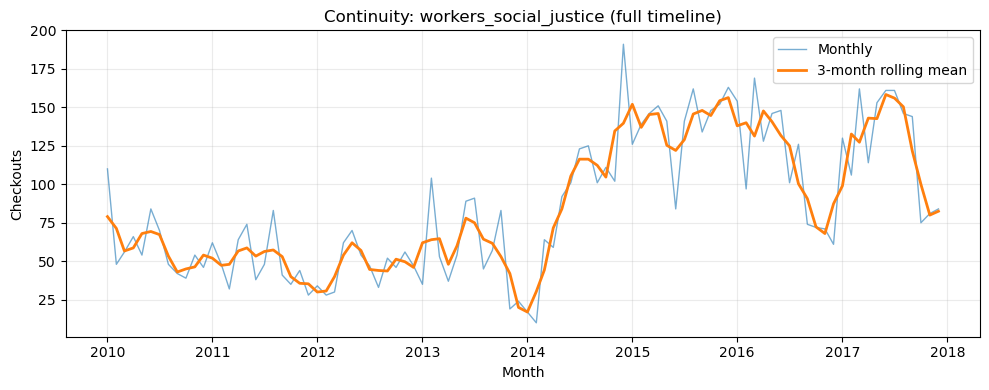

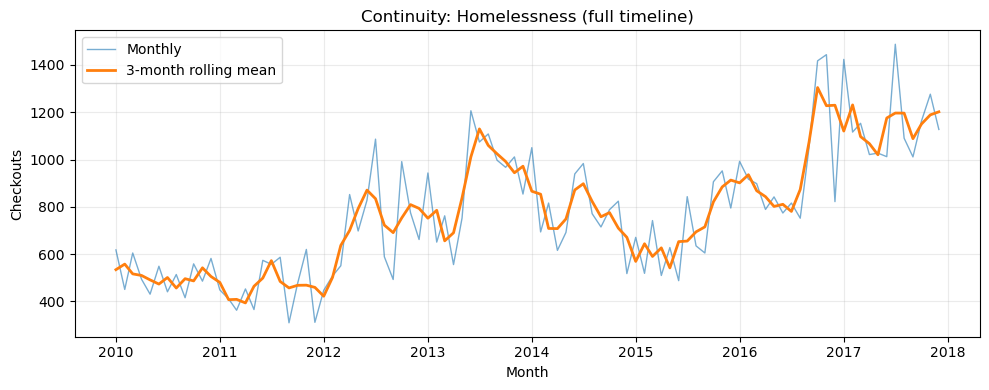

In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


def plot_continuity(ts, subject, roll=3):
    
    d = (ts.loc[ts['SubjectCategory']==subject, ['Date','Checkouts']]
            .sort_values('Date').copy())
    d['roll'] = d['Checkouts'].rolling(roll, center=True, min_periods=1).mean()

    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(d['Date'], d['Checkouts'], lw=1, alpha=0.6, label='Monthly')
    ax.plot(d['Date'], d['roll'], lw=2, label=f'{roll}-month rolling mean')
    ax.set_title(f'Continuity: {subject} (full timeline)')
    ax.set_xlabel('Month')
    ax.set_ylabel('Checkouts')
    ax.legend()
    ax.grid(alpha=.25)
    plt.tight_layout()
    plt.show()



plot_continuity(ts, subject='workers_social_justice')
plot_continuity(ts, subject='Homelessness')

In [201]:
its_analysis(ts, "workers_social_justice", "2012-04-01", window_months=6)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
--- ITS Results for workers_social_justice (±6 months) ---

                            OLS Regression Results                            
Dep. Variable:              Checkouts   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     8.360
Date:                Wed, 15 Oct 2025   Prob (F-statistic):            0.00756
Time:                        16:40:35   Log-Likelihood:                -39.704
No. Observations:                  12   AIC:                             87.41
Df Residuals:                       8   BIC:                             89.35
Df Model:                           3                     

/Users/benjaminwinsemius/miniconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [203]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

def its_analysis_basic(ts, subject, event_date, window_months=6):
    """
    
      - Seasonality: Fourier (sin12, cos12) for short windows
    """
    # 1) subset one topic and prep time
    d = (ts.loc[ts['SubjectCategory'] == subject, ['Date','Checkouts']]
           .copy().sort_values('Date').reset_index(drop=True))
    d['Date']  = pd.to_datetime(d['Date'])
    d['year']  = d['Date'].dt.year
    d['month'] = d['Date'].dt.month
    d['t']     = np.arange(len(d))

    # 2) center on event month (nearest if exact missing)
    evtM = pd.to_datetime(event_date).to_period('M')
    if (d['Date'].dt.to_period('M') == evtM).any():
        t0 = d.index[d['Date'].dt.to_period('M') == evtM][0]
    else:
        off = (d['Date'].dt.to_period('M').astype(int) - evtM.astype(int)).abs()
        t0  = int(off.idxmin())
    d['time_c'] = d['t'] - t0

    # 3) ITS regressors
    d['post_event']       = (d['time_c'] >= 0).astype(int)            # level step at event
    d['time_after_event'] = d['time_c'].clip(lower=0)                 # post-event slope

    # 4) restrict window
    d = d.loc[d['time_c'].between(-window_months, window_months)].copy()
    n = len(d)

    # 5) seasonality: Fourier for short windows; month FE if enough obs
    if n < 20:
        w = 2*np.pi*d['month']/12.0
        d['sin12'], d['cos12'] = np.sin(w), np.cos(w)
        formula = "Checkouts ~ time_c + post_event + time_after_event + sin12 + cos12"
        season_note = "Fourier (sin12, cos12)"
    else:
        formula = "Checkouts ~ time_c + post_event + time_after_event + C(month)"
        season_note = "Month fixed effects"

    print(f"Obs in window: {n} | Seasonality: {season_note}")
    res = smf.ols(formula, data=d).fit()
    print(res.summary())
    return d, res

# Example call:
d_ws, res_ws = its_analysis_basic(ts, "workers_social_justice", "2012-04-01", window_months=6)


Obs in window: 13 | Seasonality: Fourier (sin12, cos12)
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:              Checkouts   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     5.465
Date:                Wed, 15 Oct 2025   Prob (F-statistic):             0.0230
Time:                        16:41:18   Log-Likelihood:                -41.408
No. Observations:                  13   AIC:                             94.82
Df Residuals:                       7   BIC:                             98.21
Df Model:                           5                         

/Users/benjaminwinsemius/miniconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [215]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

def its_analysis_pulse(ts, subject, event_date, window_months=6, pulse_len=2):
    d = (ts.loc[ts['SubjectCategory'] == subject, ['Date','Checkouts']]
           .copy().sort_values('Date').reset_index(drop=True))
    d['Date']  = pd.to_datetime(d['Date'])
    d['year']  = d['Date'].dt.year
    d['month'] = d['Date'].dt.month
    d['t']     = np.arange(len(d))

    # 2) center on event month 
    evtM = pd.to_datetime(event_date).to_period('M')
    if (d['Date'].dt.to_period('M') == evtM).any():
        t0 = d.index[d['Date'].dt.to_period('M') == evtM][0]
    else:
        off = (d['Date'].dt.to_period('M').astype(int) - evtM.astype(int)).abs()
        t0  = int(off.idxmin())
    d['time_c'] = d['t'] - t0

    # 3) define pulse & post-pulse terms
  
    d['pulse'] = d['time_c'].between(0, pulse_len-1).astype(int)
    # slope change begins AFTER the pulse ends
    d['time_after_pulse'] = (d['time_c'] - (pulse_len-1)).clip(lower=0)

    # 4) restrict window
    d = d.loc[d['time_c'].between(-window_months, window_months)].copy()
    n = len(d)

    # 5) seasonality: Fourier for short windows
    if n < 20:
        w = 2*np.pi*d['month']/12.0
        d['sin12'], d['cos12'] = np.sin(w), np.cos(w)
        formula = "Checkouts ~ time_c + pulse + time_after_pulse + sin12 + cos12"
        season_note = "Fourier (sin12, cos12)"
    else:
        formula = "Checkouts ~ time_c + pulse + time_after_pulse + C(month)"
        season_note = "Month fixed effects"

    print(f"Obs in window: {n} | Seasonality: {season_note} | pulse_len={pulse_len}")
    res = smf.ols(formula, data=d).fit()
    print(res.summary())
    return d, res
d_ws, res_ws = its_analysis_pulse(
    ts, "Homelessness", "2016-10-17", window_months=6, pulse_len=2
)

Obs in window: 13 | Seasonality: Fourier (sin12, cos12) | pulse_len=2
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:              Checkouts   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     2.455
Date:                Wed, 15 Oct 2025   Prob (F-statistic):              0.137
Time:                        20:34:23   Log-Likelihood:                -83.857
No. Observations:                  13   AIC:                             179.7
Df Residuals:                       7   BIC:                             183.1
Df Model:                           5           

/Users/benjaminwinsemius/miniconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


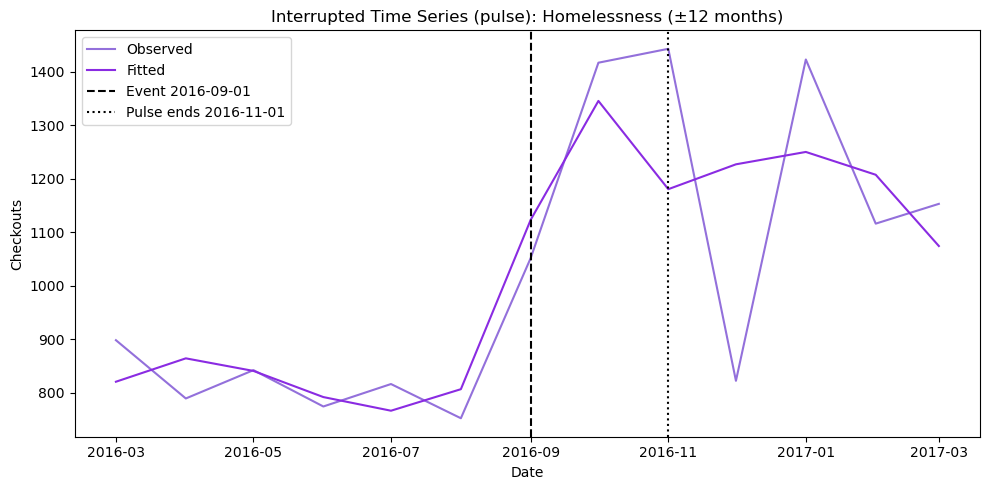

In [227]:

import pandas as pd
import matplotlib.pyplot as plt

def plot_its_pulse_basic(d, res, event_date, subject, window_months=12, pulse_len=2):
    event_date = pd.to_datetime(event_date)
    fitted = res.get_prediction(d).predicted_mean

    event = event_date.to_period("M").to_timestamp()
    pulse_end = (event_date + pd.offsets.MonthBegin(pulse_len)).to_period("M").to_timestamp()


    plt.figure(figsize=(10, 5))
    plt.plot(d["Date"], d["Checkouts"], label="Observed", color="mediumpurple")
    plt.plot(d["Date"], fitted, label="Fitted", color="blueviolet")

    plt.axvline(evt, color="black", linestyle="--", label=f"Event {event.date()}")
    plt.axvline(pulse_end, color="black", linestyle=":", label=f"Pulse ends {pulse_end.date()}")

    plt.title(f"Interrupted Time Series (pulse): {subject} (±{window_months} months)")
    plt.xlabel("Date")
    plt.ylabel("Checkouts")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_its_pulse_basic(
    d_ws, res_ws,
    event_date="2016-09-17",
    subject="Homelessness",
    window_months=12,
    pulse_len=2
)



In [70]:
workers_df = df_filtered[df_filtered["SubjectCategory"] == "Homelessness"]

# Get both Title and Subject for each match
workers_list = workers_df[["Title", "Subjects"]].values.tolist()

# Print nicely
for title, subject in workers_list:
    print(f"{title}  -->  {subject}")



The American way of poverty : how the other half still lives / Sasha Abramsky.  -->  poverty united states
The American way of poverty : how the other half still lives / Sasha Abramsky.  -->  poverty united states
The American way of poverty : how the other half still lives / Sasha Abramsky.  -->  poverty united states
The American way of poverty : how the other half still lives / Sasha Abramsky.  -->  poverty united states
The American way of poverty : how the other half still lives / Sasha Abramsky.  -->  poverty united states
The American way of poverty : how the other half still lives / Sasha Abramsky.  -->  poverty united states
Why nations fail : the origins of power, prosperity and poverty / Daron Acemoglu and James A. Robinson.  -->  poverty developing countries
Why nations fail : the origins of power, prosperity and poverty / Daron Acemoglu and James A. Robinson.  -->  poverty developing countries
Why nations fail : the origins of power, prosperity and poverty / Daron Acemoglu